# REINFORCE on short corridor switched actions (Sutton & Barto Ch 13)

## REINFORCE: Monte Carlo Policy Gradient
1 ) generate episode

2 ) loop over each timestep 
- compute return $G_t = \sum_{k=t}^T \gamma^{k-t-1} r_k $
- calculate baselined target $\delta_t = G_t - \hat{v}(s;w) $
- update value weights $ w_{t+1} = w_t + \alpha_w \delta_t \nabla_w \hat{v}(s;w) $ 
- update policy theta $ \theta_{t+1} = \theta_{t} + \alpha_\theta \gamma^t \delta_t \nabla_\theta log \space \pi (A_t|S_t;\theta)$

## simple derivation of policy gradient
$ J(\theta) \equiv v_{\pi_\theta}(s_0) = E_{\pi}[G_0|\pi=\pi_\theta] $
- let $\tau = [(s_0,a_0),...,(s_T,a_T)] $ be some trajectory 

$ E_{\pi}[G_0|\pi=\pi_\theta] = \sum_\tau Pr(\tau|\pi_\theta)G_0(\tau) $
- where $G_0(\tau)$ is return on trajectory
- take gradient and rearange
    - note because trajectory conditioned on policy, trajectory return d/n depend on policy

$\nabla_\theta \sum_\tau Pr(\tau|\pi_\theta)G_0(\tau) = \sum_\tau G_0(\tau) \nabla_\theta Pr(\tau|\pi_\theta) $

- "gradient of log trick" follows from derivative of log and chain rule:

$ \nabla_\theta log(Pr(\theta)) = \frac{1}{Pr(\theta)} \nabla_\theta Pr(\theta) $

$ Pr(\theta) \nabla_\theta log(Pr(\theta)) = \nabla_\theta Pr(\theta) $

- substitute $\nabla_\theta Pr(\tau|\pi_\theta)$ for $ Pr(\tau|\pi_\theta) \nabla_\theta log(Pr(\tau|\pi_\theta))$

$ \sum_\tau G_0(\tau) \nabla_\theta Pr(\tau|\pi_\theta) =  \sum_\tau G_0(\tau) Pr(\tau|\pi_\theta) \nabla_\theta log(Pr(\tau|\pi_\theta)) $

- back to expectation 

$ = E [G_0(\tau) \nabla_\theta log(Pr(\tau|\pi_\theta)) |\pi=\pi_\theta] $


- reminder that $log(ab) = log(a) + log(b)$
- and since $Pr(\tau|\pi_\theta) = \prod_k \pi_\theta(a_k|s_k)N(s_{k+1}|s_k,a_k) $
- where $N(.|.)$ is environment transition, and sum is over trajectory elements
- therefore

$ \nabla_\theta log(Pr(\tau|\pi_\theta)) = \nabla_\theta \sum_k [log(\pi_\theta(a_k|s_k)) + log(N(s_{k+1}|s_k,a_k)) \$

- and becuase environment does not depend on policy:

$ = \sum_k \nabla_\theta \pi_\theta(a_k|s_k))$

- therefore:

$ = E [G_0(\tau) \nabla_\theta log(\pi_\theta(a_k|s_k)) ] $

In [1]:
import numpy as np
import torch as tr
from matplotlib import pyplot as plt

# env: short corridor with switched actions

In [2]:
class Env():
  def __init__(self):
    self.st = 0
    self.t = 0
    ## free param
    self.maxt = 100 
    None
    
  def __call__(self,action):
    if self.st == 0:
      if action:
        stp = 1
      else:
        stp = 0
    elif self.st == 1:
      if action:
        stp = 0
      else:
        stp = 2
    elif self.st == 2:
      if action:
        stp = 3
      else:
        stp = 1
    # update internal state
    self.st = stp
    reward = -1 
    self.t += 1
    if self.t >= self.maxt:
      done = True
    elif stp == 3:
      done = True
    else:
      done = False
    return stp,reward,done

## helper
def compute_returns(rewards,gamma=1.0):
    """ 
    given rewards, compute discounted return
    G_t = sum_k [g^k * r(t+k)]; k=0...T-t
    """ 
    T = len(rewards) 
    returns = np.array([
        np.sum(np.array(
            rewards[t:])*np.array(
            [gamma**i for i in range(T-t)]
        )) for t in range(T)
    ])
    return returns

# agent

In [3]:
class Agent(tr.nn.Module):
  
  def __init__(self,alfa,bmode):
    super().__init__()
    # learning rate
    self.alpha_pi = alfa[0]
    self.alpha_val = alfa[1]
    # 
    self.build()
    self.baseline = self._get_baseline(bmode)
    # 
    return None
  
  def build(self):
    # policy params
    self.theta = tr.nn.Linear(1,2,bias=False)
    self.theta.weight = tr.nn.Parameter(
        tr.Tensor([[0],[5.]] # init greedy right
      ),requires_grad=True)
    # value params
    self.vweights = tr.nn.Parameter(tr.Tensor([0]))
    # optimization
    self.optiop = tr.optim.Adam(
      self.parameters(), 
      lr=self.alpha_pi
    )
    return None
    
  def forward(self):
    return self.theta(tr.Tensor([1])).softmax(-1)

  def act(self):
    pr_right = self.forward()[0]
    action = np.random.binomial(1,pr_right.detach().numpy())
    return action
 
  
  def _get_baseline(self,bmode):
    if type(bmode)==type(None):
      return lambda x: 0
    if bmode=='value':
      return lambda s: self.vweights
  
 
  def update(self,states,actions,rewards):
    returns = compute_returns(rewards)
    L = []
    for St,At,Gt in zip(states,actions,returns):
      ## compute "loss"
      delta = Gt - self.baseline(St)
      piAt = self.forward()[At]
      los_pi = delta*tr.log(piAt)
      # update pi step
      self.optiop.zero_grad()
      los_pi.backward()
      self.optiop.step()
      # value loss
      los_val = tr.square(self.vweights - Gt)
      # update value step
      self.optiop.zero_grad()
      los_val.backward()
      self.optiop.step()
    return None 

  
# a= Agent([0.05,0.05],None)
# a.update([0],[0],[-1])

# run

In [4]:
def run_experiment(ns,neps,kw):
  """ 
  REINFORCE agent-environment logic
  """
  score = np.zeros((ns,neps))
  for seed in range(ns):
    agent = Agent(**kw)
    # episode loop
    for ep in range(neps):
      env = Env()
      # trial loop
      done = False
      at,stp = 0,0
      A = []
      R = []
      S = []
      while not done:
        st = stp
        S.append(st)
        stp,reward,done = env(at)
        at = agent.act()
        A.append(at)
        R.append(reward)
      # update
      agent.update(S,A,R)
      score[seed,ep] = np.sum(R)
  
  return score

# score = run_experiment(1,1,{'alfa':[0.05,0.05],'bmode':'value'})

### learning rate experiment
- without baseline

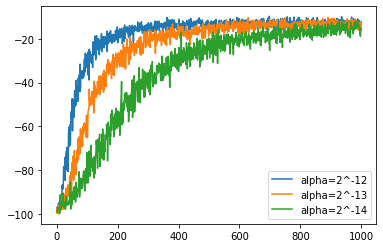

In [6]:
ns,neps = 50,1000
L = [-12,-13,-14]

kwargs = {'bmode':None}

for a in L:
  kwargs['alfa'] = [2**a,0]
  score = run_experiment(ns,neps,kwargs)
  plt.plot(score.mean(0),label='alpha=2^%i'%a)
plt.legend()

### baseline experiment

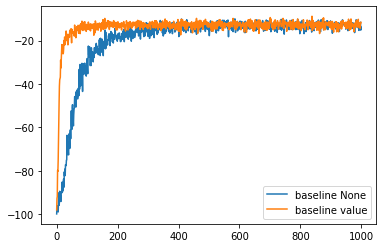

In [7]:
ns,neps = 50,1000

aL = [[2**-12,0],[2**-9,2**-6]]
mL = [None,'value']

for alfa,bmode in zip(aL,mL):
  kwargs = {'alfa':alfa,'bmode':bmode}
  score = run_experiment(ns,neps,kwargs)
  plt.plot(score.mean(0),label='baseline %s'%bmode)
plt.legend()

### resources
- open AI resources [link](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html)
    - blogs and papers